Loading aethalometer data...
Loaded aethalometer data with 1095086 observations
Resampling aethalometer data to daily averages...
Loading HIPS data...
Loaded HIPS data with 104 matched observations
Error loading HIPS data: DataFrame must have Month column or DatetimeIndex
Selected 1 columns for aethalometer analysis

Analyzing aethalometer data by detailed season...


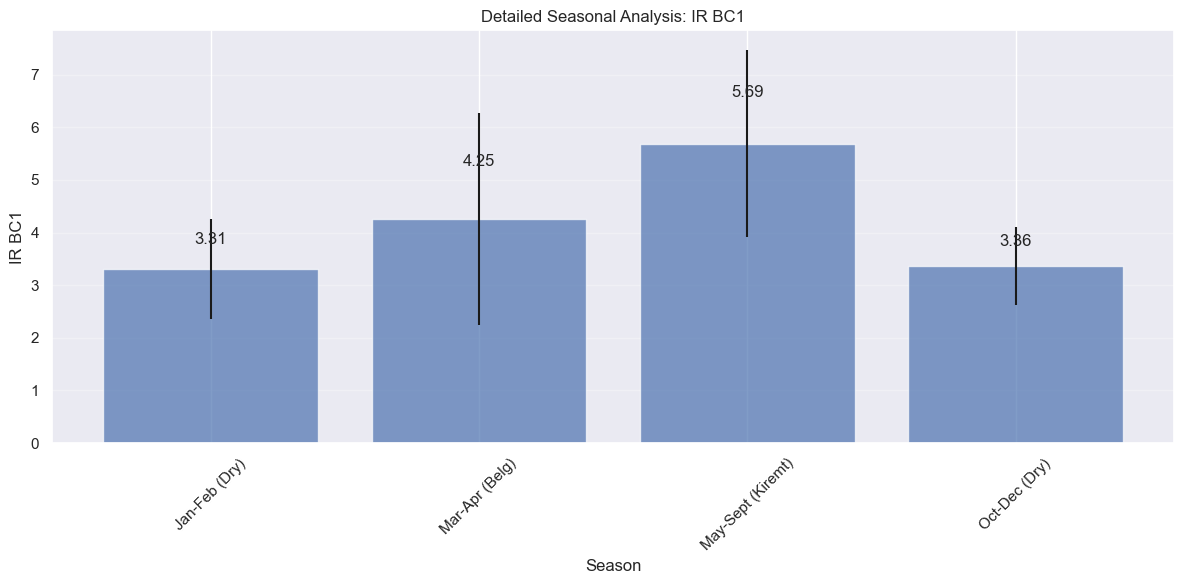

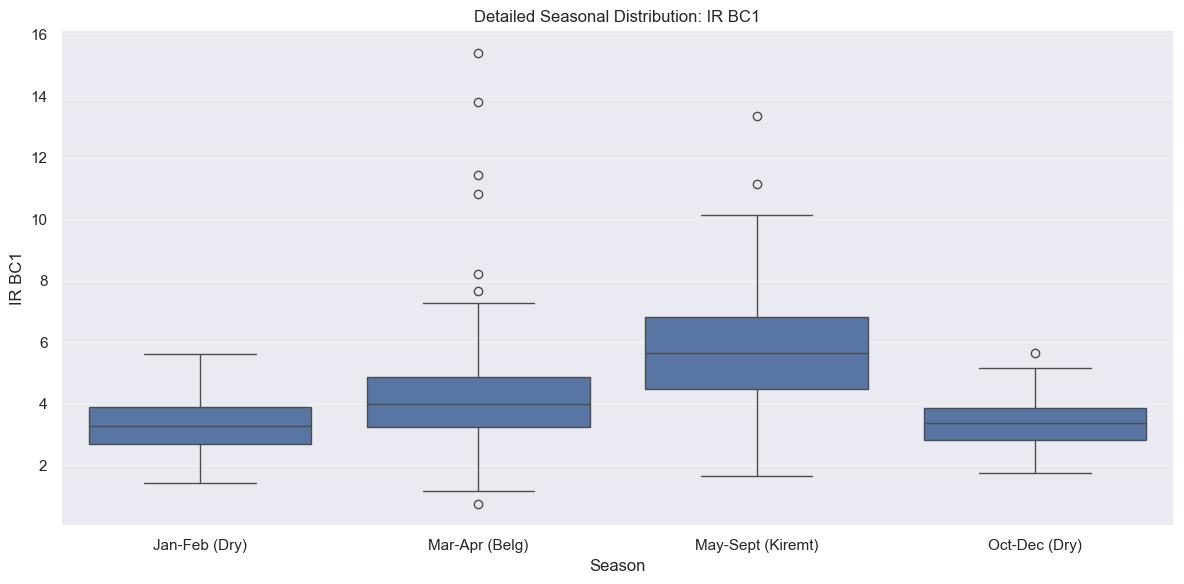


Analyzing biomass burning contribution by season...
No biomass burning percentage/fraction columns found

Comparing biomass burning results with previous findings...
No seasonal statistics available for comparison

Analyzing seasonal patterns across years...


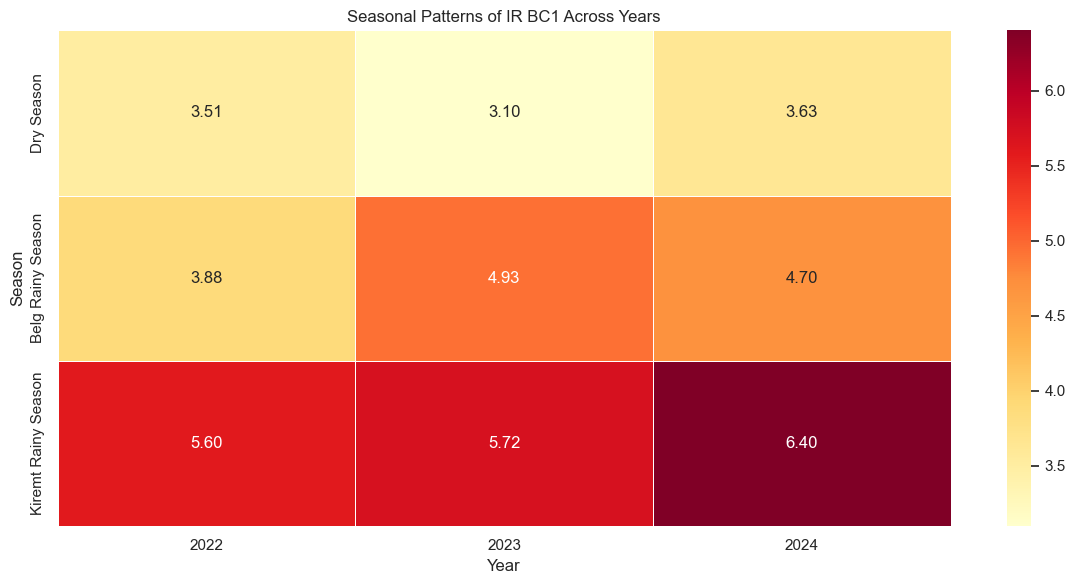

<Figure size 1200x600 with 0 Axes>

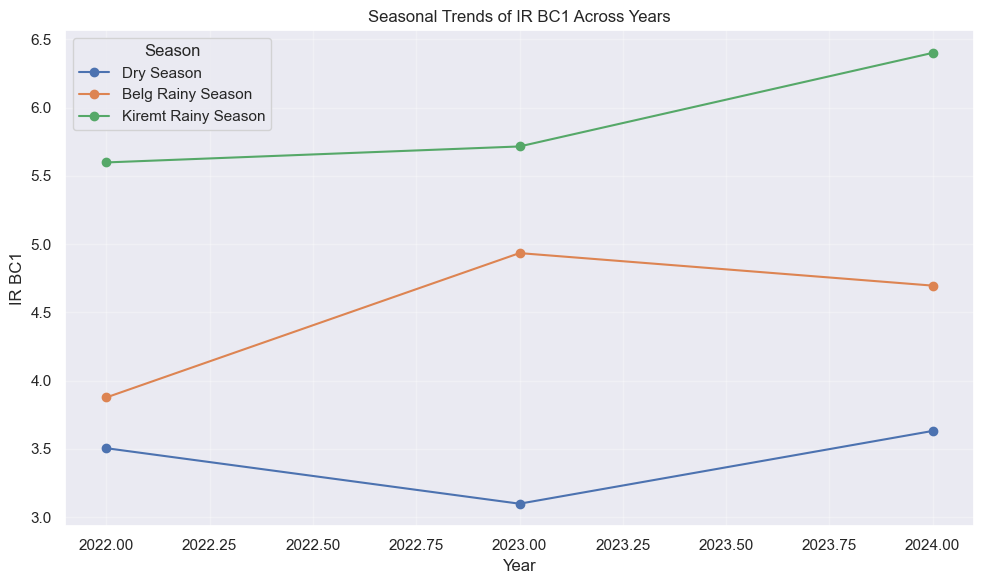


Focusing on 2023 data specifically...
Analyzing 2023 data with 365 observations


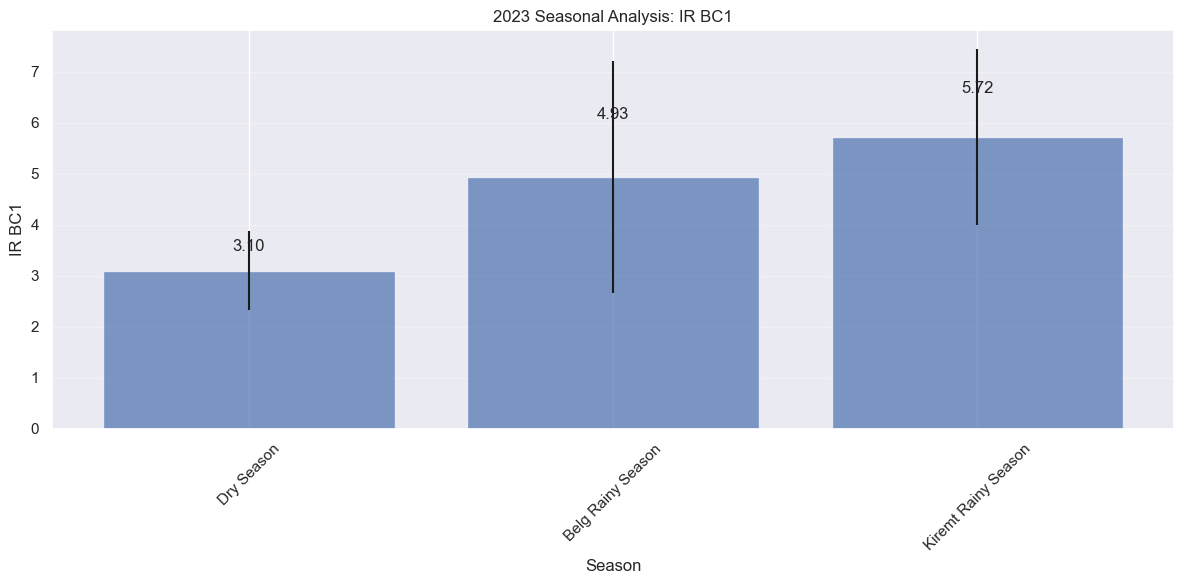


Saving results...

Analysis complete. Results saved to output/seasonal_analysis


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from datetime import datetime
import calendar

# Set plot style
plt.style.use('default')
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

def load_aethalometer_data(filepath):
    """
    Load and preprocess aethalometer data
    """
    # Read the CSV file
    df = pd.read_csv(filepath)
    
    # Convert to datetime and set timezone
    df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)'], utc=True)
    df['Time (Local)'] = df['Time (UTC)'].dt.tz_convert('Africa/Addis_Ababa')
    df.set_index('Time (Local)', inplace=True)
    
    # Define BC columns
    bc_columns = [
        # UV measurements
        'UV BC1', 'UV BC2', 'UV BCc',
        # Blue measurements
        'Blue BC1', 'Blue BC2', 'Blue BCc',
        # Green measurements
        'Green BC1', 'Green BC2', 'Green BCc',
        # Red measurements
        'Red BC1', 'Red BC2', 'Red BCc',
        # IR measurements
        'IR BC1', 'IR BC2', 'IR BCc'
    ]
    
    # Convert from ng/m³ to µg/m³ for all BC columns
    for col in bc_columns:
        if col in df.columns:
            df[col] = df[col] / 1000
        else:
            print(f"Warning: Column {col} not found - skipping")
    
    # Add time-based columns
    df['Month'] = df.index.month
    df['Hour'] = df.index.hour
    df['Year'] = df.index.year
    df['DayOfWeek'] = df.index.dayofweek
    
    # Handle outliers and negative values for all BC columns
    for col in bc_columns:
        if col in df.columns:
            # Remove negative values
            df.loc[df[col] < 0, col] = np.nan
            
            # Remove extreme outliers (3 std dev)
            mean = df[col].mean()
            std = df[col].std()
            upper_limit = mean + 3*std
            df.loc[df[col] > upper_limit, col] = np.nan
    
    print(f"Loaded aethalometer data with {len(df)} observations")
    return df, bc_columns

def load_hips_data(etad_path, ftir_paths):
    """
    Load and process HIPS data
    """
    # Load ETAD data
    etad_data = pd.read_csv(etad_path)
    etad_data['SampleDate'] = pd.to_datetime(etad_data['SampleDate'])
    
    # Load and combine FTIR data from multiple batches
    ftir_dataframes = []
    for path in ftir_paths:
        df = pd.read_csv(path)
        ftir_dataframes.append(df)
    
    ftir_data = pd.concat(ftir_dataframes, ignore_index=True)
    ftir_data['date'] = pd.to_datetime(ftir_data['date'])
    
    # Filter for ETAD site
    etad_data_filtered = etad_data[etad_data['Site'] == 'ETAD'].copy()
    ftir_data_filtered = ftir_data[ftir_data['site'] == 'ETAD'].copy()
    
    # Match ETAD and FTIR data by date
    analysis_data = etad_data_filtered.copy()
    analysis_data['FTIR_EC'] = np.nan
    
    matches_found = 0
    for idx, row in analysis_data.iterrows():
        matching_ftir = ftir_data_filtered[
            (ftir_data_filtered['date'] == row['SampleDate'])
        ]
        if not matching_ftir.empty:
            analysis_data.at[idx, 'FTIR_EC'] = matching_ftir.iloc[0]['FTIR_EC']
            matches_found += 1
    
    # Convert columns to numeric
    analysis_data['FTIR_EC'] = pd.to_numeric(analysis_data['FTIR_EC'], errors='coerce')
    analysis_data['Fabs'] = pd.to_numeric(analysis_data['Fabs'], errors='coerce')
    
    # Remove rows with missing values
    clean_data = analysis_data.dropna(subset=['FTIR_EC', 'Fabs'])
    
    print(f"Loaded HIPS data with {len(clean_data)} matched observations")
    return clean_data

def map_detailed_seasons(month):
    """Map months to detailed seasonal periods"""
    if month in [1, 2]:
        return 'Jan-Feb (Dry)'
    elif month in [3, 4]:
        return 'Mar-Apr (Belg)'
    elif month in [5, 6, 7, 8, 9]:
        return 'May-Sept (Kiremt)'
    else:  # months 10, 11, 12
        return 'Oct-Dec (Dry)'

def map_ethiopian_seasons(month):
    """Map months to Ethiopian seasons"""
    if month in [10, 11, 12, 1, 2]:
        return 'Dry Season'
    elif month in [3, 4, 5]:
        return 'Belg Rainy Season'
    else:  # months 6-9
        return 'Kiremt Rainy Season'

def add_season_columns(df):
    """
    Add different season classification columns to the dataframe
    """
    # Make sure Month column exists
    if 'Month' not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df['Month'] = df.index.month
        else:
            raise ValueError("DataFrame must have Month column or DatetimeIndex")
    
    # Add month name for better readability
    df['Month_Name'] = df['Month'].apply(lambda m: calendar.month_abbr[m])
    
    # Add standard seasons
    df['Season_Standard'] = df['Month'].apply(lambda m: 
        'Winter' if m in [12, 1, 2] else
        'Spring' if m in [3, 4, 5] else
        'Summer' if m in [6, 7, 8] else
        'Fall'
    )
    
    # Add Ethiopian seasons
    df['Season'] = df['Month'].apply(map_ethiopian_seasons)
    
    # Add detailed seasonal periods
    df['Detailed_Season'] = df['Month'].apply(map_detailed_seasons)
    
    # Add season-year column for tracking across years
    if 'Year' in df.columns:
        df['Season_Year'] = df['Season'] + ' ' + df['Year'].astype(str)
    
    return df

def resample_aethalometer_data(df, freq='1D'):
    """
    Resample aethalometer data to the specified frequency
    """
    # Identify numeric columns suitable for averaging
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Exclude categorical columns that shouldn't be averaged
    cols_to_exclude = ['Month', 'Hour', 'Year', 'DayOfWeek']
    numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]
    
    # Resample numeric columns
    resampled = df[numeric_cols].resample(freq).mean()
    
    # Add time-based columns
    resampled['Month'] = resampled.index.month
    resampled['Year'] = resampled.index.year
    
    # Add season columns
    resampled = add_season_columns(resampled)
    
    return resampled

def analyze_by_detailed_season(df, value_columns, output_dir=None):
    """
    Analyze data by detailed seasonal periods
    """
    # Define the order of detailed seasons
    detailed_season_order = ['Jan-Feb (Dry)', 'Mar-Apr (Belg)', 'May-Sept (Kiremt)', 'Oct-Dec (Dry)']
    
    # Create stats dataframe
    stats_results = {}
    
    for col in value_columns:
        if col in df.columns:
            # Group by detailed season
            seasonal_stats = df.groupby('Detailed_Season')[col].agg([
                'count', 'mean', 'std', 'min', 'max'
            ]).round(3)
            
            # Reorder seasons
            seasonal_stats = seasonal_stats.reindex(detailed_season_order)
            
            # Store results
            stats_results[col] = seasonal_stats
            
            # Create bar plot
            plt.figure(figsize=(12, 6))
            
            # Extract mean values
            means = seasonal_stats['mean']
            stds = seasonal_stats['std']
            
            # Create bar plot with error bars
            bars = plt.bar(range(len(means)), means, yerr=stds, alpha=0.7)
            
            # Add value labels
            for i, bar in enumerate(bars):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + stds.iloc[i]/2,
                        f'{height:.2f}', ha='center')
            
            plt.title(f'Detailed Seasonal Analysis: {col}')
            plt.xlabel('Season')
            plt.ylabel(col)
            plt.xticks(range(len(means)), detailed_season_order, rotation=45)
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            
            if output_dir:
                os.makedirs(output_dir, exist_ok=True)
                plt.savefig(os.path.join(output_dir, f'detailed_seasonal_{col}.png'), dpi=300)
            
            plt.show()
            
            # Create box plot
            plt.figure(figsize=(12, 6))
            
            sns.boxplot(data=df, x='Detailed_Season', y=col, order=detailed_season_order)
            
            plt.title(f'Detailed Seasonal Distribution: {col}')
            plt.xlabel('Season')
            plt.ylabel(col)
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            
            if output_dir:
                plt.savefig(os.path.join(output_dir, f'detailed_seasonal_boxplot_{col}.png'), dpi=300)
            
            plt.show()
    
    return stats_results

def analyze_biomass_burning_by_season(df, output_dir=None):
    """
    Analyze biomass burning contribution by season
    """
    # Check if biomass burning columns exist
    bb_cols = [col for col in df.columns if 'BB_percentage' in col or 'BB_fraction' in col]
    
    if not bb_cols:
        print("No biomass burning percentage/fraction columns found")
        return None
    
    # Define the order of detailed seasons
    detailed_season_order = ['Jan-Feb (Dry)', 'Mar-Apr (Belg)', 'May-Sept (Kiremt)', 'Oct-Dec (Dry)']
    
    # Group by detailed season
    seasonal_stats = df.groupby('Detailed_Season')[bb_cols].agg([
        'count', 'mean', 'std', 'median'
    ]).round(3)
    
    # Reorder seasons
    seasonal_stats = seasonal_stats.reindex(detailed_season_order)
    
    # Print summary
    print("\nBiomass Burning Contribution by Season:")
    print("-" * 50)
    
    for col in bb_cols:
        print(f"\n{col}:")
        for season in detailed_season_order:
            if season in seasonal_stats.index:
                count = seasonal_stats.loc[season, (col, 'count')]
                mean_val = seasonal_stats.loc[season, (col, 'mean')]
                std_val = seasonal_stats.loc[season, (col, 'std')]
                print(f"  {season}: {mean_val:.1f}% ± {std_val:.1f}% (n={count})")
    
    print("-" * 50)
    
    # Create bar plot
    plt.figure(figsize=(12, 6))
    
    for i, col in enumerate(bb_cols):
        # Extract means and errors
        means = seasonal_stats.loc[:, (col, 'mean')]
        stds = seasonal_stats.loc[:, (col, 'std')]
        
        # Calculate position
        width = 0.8 / len(bb_cols)
        offset = width * (i - len(bb_cols)/2 + 0.5)
        
        # Create bars
        x_pos = np.arange(len(detailed_season_order)) + offset
        bars = plt.bar(x_pos, means, width, yerr=stds, alpha=0.7,
                      label=col.replace('BB_percentage_', '').replace('BB_fraction_', ''))
        
        # Add value labels
        for j, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + stds.iloc[j],
                    f'{height:.1f}%', ha='center', va='bottom')
    
    plt.title('Biomass Burning Contribution by Season')
    plt.xlabel('Season')
    plt.ylabel('Biomass Burning Percentage (%)')
    plt.xticks(range(len(detailed_season_order)), detailed_season_order, rotation=45)
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3, axis='y')
    plt.legend()
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'biomass_burning_by_season.png'), dpi=300)
    
    plt.show()
    
    # Create violin plots
    plt.figure(figsize=(14, 6))
    
    for i, col in enumerate(bb_cols[:2]):  # Limit to 2 columns for clarity
        plt.subplot(1, min(2, len(bb_cols)), i+1)
        
        sns.violinplot(data=df, x='Detailed_Season', y=col, order=detailed_season_order)
        
        plt.title(f'{col} Distribution')
        plt.xlabel('Season')
        plt.ylabel('Biomass Burning (%)')
        plt.ylim(0, 100)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'biomass_burning_distribution.png'), dpi=300)
    
    plt.show()
    
    return seasonal_stats

def compare_with_previous_findings(seasonal_stats, output_dir=None):
    """
    Compare current biomass burning results with previous findings
    """
    if seasonal_stats is None:
        print("No seasonal statistics available for comparison")
        return None
    
    # Create mapping from detailed seasons to main seasons
    season_mapping = {
        'Jan-Feb (Dry)': 'Dry Season',
        'Mar-Apr (Belg)': 'Belg Rainy Season',
        'May-Sept (Kiremt)': 'Kiremt Rainy Season',
        'Oct-Dec (Dry)': 'Dry Season'
    }
    
    # Define previous findings
    previous_results = pd.DataFrame({
        'Season': ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season'],
        'Previous_Study_BB%': [10, 30, 50]
    })
    
    # Get BB percentage columns
    bb_cols = []
    for col in seasonal_stats.columns.levels[0]:
        if 'BB_percentage' in col or 'BB_fraction' in col:
            bb_cols.append(col)
    
    if not bb_cols:
        print("No biomass burning columns found in seasonal statistics")
        return None
    
    # Create current results dataframe
    current_results = pd.DataFrame(index=previous_results['Season'])
    
    for col in bb_cols:
        # Create temporary dataframe with means
        temp_df = pd.DataFrame({
            'Detailed_Season': seasonal_stats.index,
            f'Current_{col}': seasonal_stats.loc[:, (col, 'mean')].values
        })
        
        # Map to main seasons
        temp_df['Season'] = temp_df['Detailed_Season'].map(season_mapping)
        
        # Aggregate by main season (average Jan-Feb and Oct-Dec for Dry Season)
        main_season_means = temp_df.groupby('Season')[f'Current_{col}'].mean()
        
        # Add to current results
        current_results[f'Current_{col}'] = main_season_means
    
    # Merge with previous results
    comparison = pd.DataFrame(previous_results['Season'])
    comparison = comparison.set_index('Season')
    comparison['Previous_Study_BB%'] = previous_results.set_index('Season')['Previous_Study_BB%']
    comparison = pd.concat([comparison, current_results], axis=1)
    
    # Print comparison
    print("\nComparison with Previous Studies:")
    print("-" * 50)
    print(comparison.round(1))
    print("-" * 50)
    
    # Create comparison bar chart
    plt.figure(figsize=(12, 6))
    
    # Get all columns to plot
    plot_cols = ['Previous_Study_BB%'] + [col for col in comparison.columns if 'Current_' in col]
    
    # Set up positions
    x = np.arange(len(comparison.index))
    width = 0.8 / len(plot_cols)
    
    # Plot bars
    for i, col in enumerate(plot_cols):
        offset = width * (i - len(plot_cols)/2 + 0.5)
        
        # Get label
        if col == 'Previous_Study_BB%':
            label = 'Previous Study'
        else:
            label = col.replace('Current_', '').replace('BB_percentage_', '').replace('BB_fraction_', '')
        
        # Create bars
        bars = plt.bar(x + offset, comparison[col], width, label=label)
        
        # Add value labels
        for j, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 1,
                    f'{height:.1f}%', ha='center', va='bottom')
    
    plt.title('Comparison with Previous Studies: Biomass Burning Contribution')
    plt.xlabel('Season')
    plt.ylabel('Biomass Burning Percentage (%)')
    plt.xticks(x, comparison.index)
    plt.ylim(0, 75)
    plt.grid(True, alpha=0.3, axis='y')
    plt.legend()
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'bb_comparison_with_previous.png'), dpi=300)
    
    plt.show()
    
    return comparison

def analyze_seasonal_patterns_across_years(df, value_columns, output_dir=None):
    """
    Analyze seasonal patterns across different years
    """
    # Check if Year column exists
    if 'Year' not in df.columns:
        print("No Year column in dataframe, cannot analyze across years")
        return None
    
    # Get unique years
    years = sorted(df['Year'].unique())
    
    if len(years) < 2:
        print(f"Only one year ({years[0]}) present in data, cannot analyze across years")
        return None
    
    # Define the order of seasons
    season_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    
    # Create results
    results = {}
    
    for col in value_columns:
        if col in df.columns:
            # Create pivot table
            pivot = pd.pivot_table(
                df, values=col, index='Season', columns='Year', aggfunc='mean'
            )
            
            # Reorder seasons
            pivot = pivot.reindex(season_order)
            
            # Store results
            results[col] = pivot
            
            # Create heatmap
            plt.figure(figsize=(12, 6))
            
            sns.heatmap(pivot, annot=True, cmap='YlOrRd', fmt='.2f', linewidths=.5)
            
            plt.title(f'Seasonal Patterns of {col} Across Years')
            plt.tight_layout()
            
            if output_dir:
                os.makedirs(output_dir, exist_ok=True)
                plt.savefig(os.path.join(output_dir, f'seasonal_heatmap_{col}.png'), dpi=300)
            
            plt.show()
            
            # Create line plot
            plt.figure(figsize=(12, 6))
            
            pivot.T.plot(marker='o')
            
            plt.title(f'Seasonal Trends of {col} Across Years')
            plt.xlabel('Year')
            plt.ylabel(col)
            plt.grid(True, alpha=0.3)
            plt.legend(title='Season')
            plt.tight_layout()
            
            if output_dir:
                plt.savefig(os.path.join(output_dir, f'seasonal_trends_{col}.png'), dpi=300)
            
            plt.show()
    
    return results

def analyze_2023_data_by_season(df, value_columns, output_dir=None):
    """
    Analyze 2023 data specifically by season
    """
    # Filter for 2023 data
    if 'Year' not in df.columns:
        df['Year'] = df.index.year
    
    df_2023 = df[df['Year'] == 2023].copy()
    
    if len(df_2023) == 0:
        print("No data for 2023 found")
        return None
    
    print(f"Analyzing 2023 data with {len(df_2023)} observations")
    
    # Define season order
    season_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    
    # Create results dictionary
    results = {}
    
    for col in value_columns:
        if col in df_2023.columns:
            # Calculate seasonal statistics
            stats = df_2023.groupby('Season')[col].agg([
                'count', 'mean', 'std', 'min', 'max'
            ]).round(3)
            
            # Reorder seasons
            stats = stats.reindex(season_order)
            
            # Store results
            results[col] = stats
            
            # Create bar plot
            plt.figure(figsize=(12, 6))
            
            # Extract means
            means = stats['mean']
            stds = stats['std']
            
            # Create bars
            bars = plt.bar(range(len(means)), means, yerr=stds, alpha=0.7)
            
            # Add value labels
            for i, bar in enumerate(bars):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + stds.iloc[i]/2,
                        f'{height:.2f}', ha='center')
            
            plt.title(f'2023 Seasonal Analysis: {col}')
            plt.xlabel('Season')
            plt.ylabel(col)
            plt.xticks(range(len(means)), means.index, rotation=45)
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            
            if output_dir:
                os.makedirs(output_dir, exist_ok=True)
                plt.savefig(os.path.join(output_dir, f'2023_seasonal_{col}.png'), dpi=300)
            
            plt.show()
    
    return results

def main():
    # Setup output directory
    output_dir = 'output/seasonal_analysis'
    os.makedirs(output_dir, exist_ok=True)
    
    # Define filepaths
    aeth_filepath = "/Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv"
    
    etad_data_path = "/Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/FTIR EC/ETAD_data_2023.csv"
    ftir_data_paths = [
        "/Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/HIPS BC/SPARTAN_FTIR data batch 2 and 3 resubmitted with MDLs.csv",
        "/Users/ahmadjalil/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/HIPS BC/SPARTAN_FTIR data_batch 4_ Nov2022 to March2024.csv"
    ]
    
    # Load aethalometer data
    print("Loading aethalometer data...")
    aeth_data, bc_columns = load_aethalometer_data(aeth_filepath)
    
    # Resample to daily
    print("Resampling aethalometer data to daily averages...")
    aeth_daily = resample_aethalometer_data(aeth_data, freq='1D')
    
    # Add detailed season columns
    aeth_daily = add_season_columns(aeth_daily)
    
    # Load HIPS data
    print("Loading HIPS data...")
    try:
        hips_data = load_hips_data(etad_data_path, ftir_data_paths)
        hips_data = add_season_columns(hips_data)
    except Exception as e:
        print(f"Error loading HIPS data: {e}")
        hips_data = None
    
    # Define columns to analyze for aethalometer data
    aeth_value_columns = []
    
    # Include IR BC1 (standard BC measurement)
    if 'IR BC1' in aeth_daily.columns:
        aeth_value_columns.append('IR BC1')
    
    # Include AAE columns
    aae_cols = [col for col in aeth_daily.columns if col.startswith('AAE_')]
    aeth_value_columns.extend(aae_cols)
    
    # Include BB percentage columns
    bb_cols = [col for col in aeth_daily.columns if col.startswith('BB_percentage_')]
    aeth_value_columns.extend(bb_cols)
    
    print(f"Selected {len(aeth_value_columns)} columns for aethalometer analysis")
    
    # Analyze aethalometer data by detailed season
    print("\nAnalyzing aethalometer data by detailed season...")
    aeth_season_stats = analyze_by_detailed_season(
        aeth_daily, aeth_value_columns, 
        os.path.join(output_dir, 'aethalometer')
    )
    
    # Analyze biomass burning contribution
    print("\nAnalyzing biomass burning contribution by season...")
    bb_stats = analyze_biomass_burning_by_season(
        aeth_daily, 
        os.path.join(output_dir, 'aethalometer')
    )
    
    # Compare with previous findings
    print("\nComparing biomass burning results with previous findings...")
    bb_comparison = compare_with_previous_findings(
        bb_stats, 
        os.path.join(output_dir, 'aethalometer')
    )
    
    # Analyze seasonal patterns across years
    print("\nAnalyzing seasonal patterns across years...")
    yearly_patterns = analyze_seasonal_patterns_across_years(
        aeth_daily, aeth_value_columns, 
        os.path.join(output_dir, 'aethalometer')
    )
    
    # Focus specifically on 2023 data
    print("\nFocusing on 2023 data specifically...")
    results_2023 = analyze_2023_data_by_season(
        aeth_daily, aeth_value_columns,
        os.path.join(output_dir, 'aethalometer/2023')
    )
    
    # If HIPS data is available, analyze it too
    if hips_data is not None:
        print("\nAnalyzing HIPS data by season...")
        hips_value_columns = ['FTIR_EC', 'Fabs']
        
        # Add BC_HIPS column if MAC value is known (assume 4.0 if not specified)
        mac = 4.0  # Default MAC value
        hips_data['BC_HIPS'] = hips_data['Fabs'] / mac
        hips_value_columns.append('BC_HIPS')
        
        hips_season_stats = analyze_by_detailed_season(
            hips_data, hips_value_columns,
            os.path.join(output_dir, 'hips')
        )
    
    # Save results
    print("\nSaving results...")
    if aeth_season_stats:
        for col, stats in aeth_season_stats.items():
            stats.to_csv(os.path.join(output_dir, f'aethalometer_{col}_seasonal_stats.csv'))
    
    if bb_stats is not None:
        bb_stats.to_csv(os.path.join(output_dir, 'biomass_burning_seasonal_stats.csv'))
    
    if results_2023:
        for col, stats in results_2023.items():
            stats.to_csv(os.path.join(output_dir, f'aethalometer_{col}_2023_stats.csv'))
    
    print(f"\nAnalysis complete. Results saved to {output_dir}")
    
    return {
        'aeth_daily': aeth_daily,
        'hips_data': hips_data,
        'aeth_season_stats': aeth_season_stats,
        'bb_stats': bb_stats,
        'bb_comparison': bb_comparison,
        'yearly_patterns': yearly_patterns,
        'results_2023': results_2023
    }

if __name__ == "__main__":
    main()